In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import signal

In [2]:
data_path_1 = Path("../datasets/1st_test")
files_1 = list(data_path_1.glob('*'))
print("num of files in set 1:", len(files_1))

num of files in set 1: 2156


In [3]:
data_path_2 = Path("../datasets/2nd_test")
files_2 = list(data_path_2.glob('*'))
print("num of files in set 2:", len(files_2))

num of files in set 2: 984


In [4]:
# Update path to match your folder structure
data_path_3 = Path("../datasets/3rd_test")
files_3 = sorted(list(data_path_3.glob('*')))

print("First file:", files_3[0].name)
print("Last file:", files_3[-1].name)
print("Total files in set 3:", len(files_3))

# Let's check if files are unique
unique_files = set(files_3)
print("\nUnique files:", len(unique_files))

First file: 2004.03.04.09.27.46
Last file: 2004.04.18.02.42.55
Total files in set 3: 6324

Unique files: 6324


In [5]:
# Cell 2: Key Analysis Functions from Phase 2
def analyze_frequency_bands(data, channel, sampling_rate=20000):
    """Analyze vibration data in three frequency bands"""
    channel_data = data[:, channel]
    
    bands = {
        'low': (20, 1000),    # Basic rotation band
        'mid': (1000, 3000),  # Early warning band
        'high': (3000, 5000)  # Damage zone band
    }
    
    filtered_signals = {}
    
    for band_name, (low_freq, high_freq) in bands.items():
        nyquist = sampling_rate / 2
        low_normalized = low_freq / nyquist
        high_normalized = high_freq / nyquist
        
        sos = signal.butter(4, [low_normalized, high_normalized], 
                          btype='bandpass', output='sos')
        
        filtered_signals[band_name] = signal.sosfilt(sos, channel_data)
    
    return filtered_signals

def analyze_signal_characteristics(filtered_bands):
    """Calculate key metrics for each frequency band"""
    analysis = {}
    
    for band_name, signal_data in filtered_bands.items():
        analysis[band_name] = {
            'RMS': np.sqrt(np.mean(signal_data**2)),
            'Peak': np.max(np.abs(signal_data)),
            'Crest': np.max(np.abs(signal_data)) / np.sqrt(np.mean(signal_data**2)),
            'Kurtosis': stats.kurtosis(signal_data)
        }
    
    return analysis

In [6]:
def extract_bearing_features(data, channels):
    """
    Extract all relevant features for a bearing from its channel(s)
    
    Args:
        data: Raw vibration data array
        channels: List of channel numbers for this bearing
    
    Returns:
        Dictionary of features
    """
    features = {}
    
    # For each channel of the bearing
    for channel in channels:
        # Get frequency bands
        bands = analyze_frequency_bands(data, channel)
        # Get characteristics for each band
        characteristics = analyze_signal_characteristics(bands)
        
        # Store features with channel identifier
        for band_name, metrics in characteristics.items():
            for metric_name, value in metrics.items():
                feature_name = f'Ch{channel+1}_{band_name}_{metric_name}'
                features[feature_name] = value
                
    return features

In [7]:
def create_feature_dataset():
    """
    Create dataset with features from all bearings (healthy and failing states)
    """
    feature_data = []
    
    # Set 1 - Inner Race (Bearing 3)
    bearing3_healthy = np.loadtxt(sorted(data_path_1.glob("*"))[0])
    bearing3_failing = np.loadtxt(sorted(data_path_1.glob("*"))[-10])
    
    # Extract features
    healthy_features = extract_bearing_features(bearing3_healthy, [4, 5])  # Channels 5,6
    healthy_features['state'] = 'healthy'
    healthy_features['failure_type'] = 'inner_race'
    feature_data.append(healthy_features)
    
    failing_features = extract_bearing_features(bearing3_failing, [4, 5])
    failing_features['state'] = 'failing'
    failing_features['failure_type'] = 'inner_race'
    feature_data.append(failing_features)
    
    # Set 1 - Roller (Bearing 4)
    files_1 = sorted(data_path_1.glob("*"))
    bearing4_failing_idx = int(len(files_1) * 0.81)  # Known failure point
    bearing4_failing = np.loadtxt(files_1[bearing4_failing_idx])
    
    failing_features = extract_bearing_features(bearing4_failing, [6, 7])  # Channels 7,8
    failing_features['state'] = 'failing'
    failing_features['failure_type'] = 'roller'
    feature_data.append(failing_features)
    
    # Set 2 - Outer Race (Bearing 1)
    bearing_s2_healthy = np.loadtxt(sorted(data_path_2.glob("*"))[0])
    bearing_s2_failing = np.loadtxt(sorted(data_path_2.glob("*"))[-10])
    
    failing_features = extract_bearing_features(bearing_s2_failing, [0])  # Channel 1
    failing_features['state'] = 'failing'
    failing_features['failure_type'] = 'outer_race'
    feature_data.append(failing_features)
    
    # Convert to DataFrame
    df = pd.DataFrame(feature_data)
    return df

# Create our feature dataset
feature_df = create_feature_dataset()
print("Features extracted:", len(feature_df.columns)-2)  # -2 for state and failure_type columns
print("\nSample features:")
print(feature_df.columns.tolist()[:5])  # Show first 5 feature names

Features extracted: 60

Sample features:
['Ch5_low_RMS', 'Ch5_low_Peak', 'Ch5_low_Crest', 'Ch5_low_Kurtosis', 'Ch5_mid_RMS']


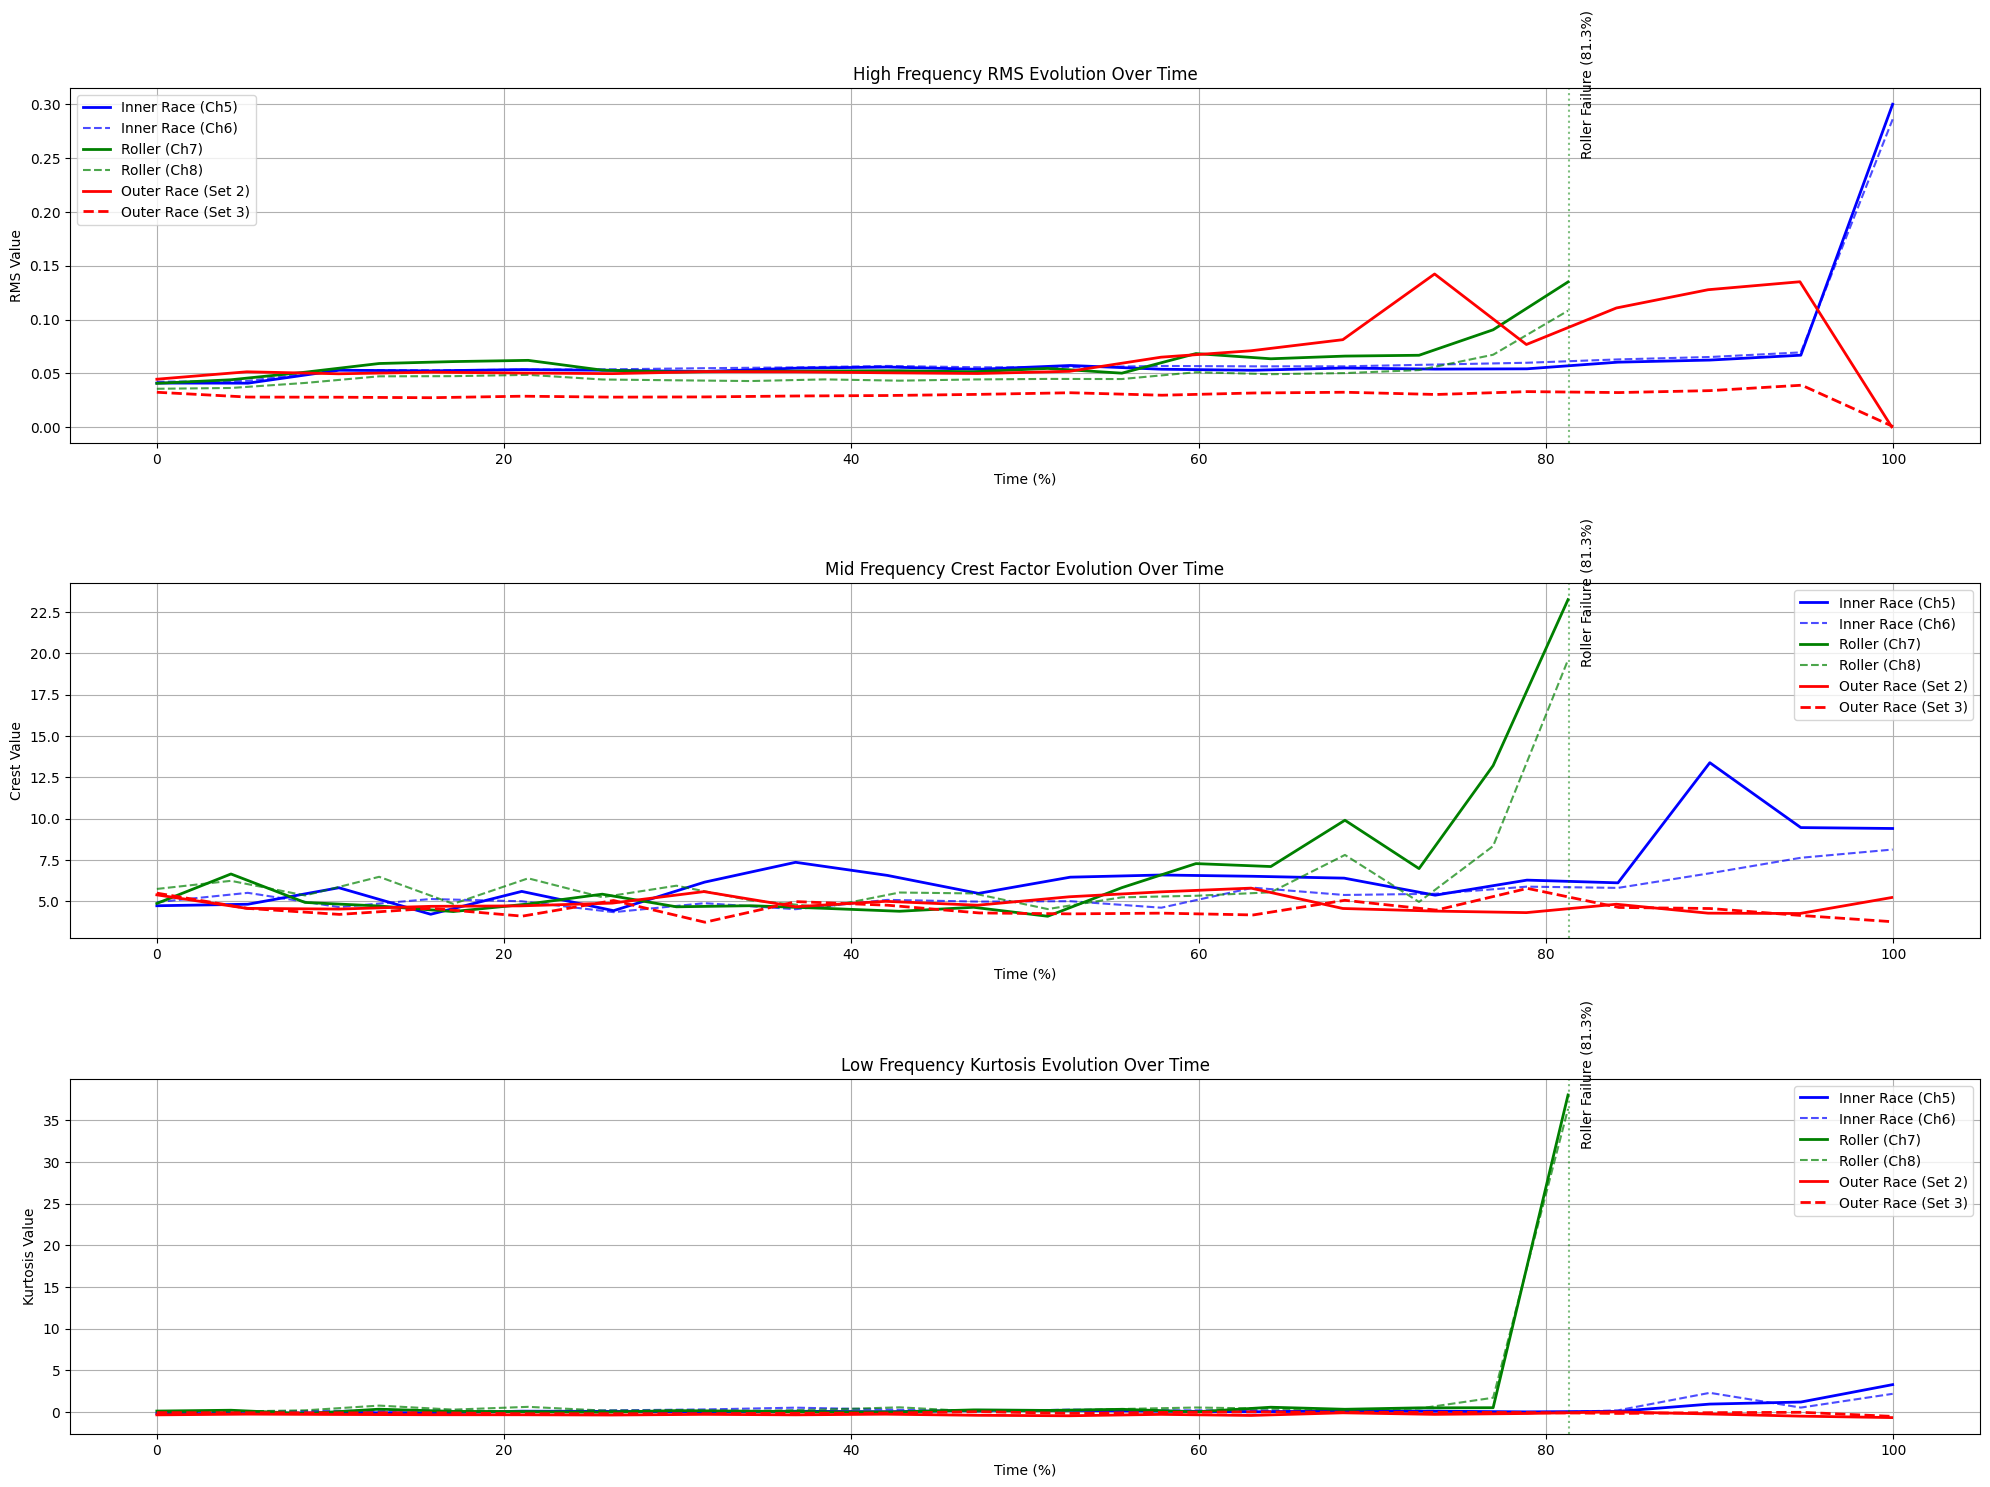

In [8]:
def plot_comprehensive_feature_evolution():
    """
    Plot all three metrics for all failure types, including both outer race failures
    """
    plt.figure(figsize=(20, 15))
    
    # Load data for all failure types
    # Set 1 - Inner Race (Bearing 3, Channels 5&6)
    files_1 = sorted(data_path_1.glob("*"))
    sample_indices = np.linspace(0, len(files_1)-1, 20, dtype=int)
    
    # Data collection for each bearing type
    features_data = {
        'inner_race': {'ch5': [], 'ch6': []},
        'roller': {'ch7': [], 'ch8': []},
        'outer_race_set2': {'ch1': []},
        'outer_race_set3': {'ch3': []}  # Added Set 3
    }
    
    # Collect Inner Race data
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        time_pct = (idx / len(files_1)) * 100
        
        # Channels 5&6 (Inner Race)
        for ch, ch_num in [(5,4), (6,5)]:
            features = extract_bearing_features(data, [ch_num])
            features['time_percentage'] = time_pct
            features_data['inner_race'][f'ch{ch}'].append(features)
    
    # Collect Roller data (up to 81.3%)
    roller_idx = int(len(files_1) * 0.813)
    roller_indices = np.linspace(0, roller_idx, 20, dtype=int)
    
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        time_pct = (idx / len(files_1)) * 100
        
        # Channels 7&8 (Roller)
        for ch, ch_num in [(7,6), (8,7)]:
            features = extract_bearing_features(data, [ch_num])
            features['time_percentage'] = time_pct
            features_data['roller'][f'ch{ch}'].append(features)
    
    # Collect Outer Race data - Set 2
    files_2 = sorted(data_path_2.glob("*"))
    sample_indices_2 = np.linspace(0, len(files_2)-1, 20, dtype=int)
    
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        time_pct = (idx / len(files_2)) * 100
        features = extract_bearing_features(data, [0])
        features['time_percentage'] = time_pct
        features_data['outer_race_set2']['ch1'].append(features)
    
    # Collect Outer Race data - Set 3 (Added)
    files_3 = sorted(data_path_3.glob("*"))
    sample_indices_3 = np.linspace(0, len(files_3)-1, 20, dtype=int)
    
    for idx in sample_indices_3:
        data = np.loadtxt(files_3[idx])
        time_pct = (idx / len(files_3)) * 100
        features = extract_bearing_features(data, [2])  # Channel 3 in Set 3
        features['time_percentage'] = time_pct
        features_data['outer_race_set3']['ch3'].append(features)
    
    # Plotting
    metrics = {
        'RMS': {'suffix': '_high_RMS', 'title': 'High Frequency RMS Evolution Over Time'},
        'Crest': {'suffix': '_mid_Crest', 'title': 'Mid Frequency Crest Factor Evolution Over Time'},
        'Kurtosis': {'suffix': '_low_Kurtosis', 'title': 'Low Frequency Kurtosis Evolution Over Time'}
    }
    
    for i, (metric, info) in enumerate(metrics.items(), 1):
        plt.subplot(3, 1, i)
        
        # Inner Race
        plt.plot([f['time_percentage'] for f in features_data['inner_race']['ch5']],
                [f[f'Ch5{info["suffix"]}'] for f in features_data['inner_race']['ch5']],
                'b-', label='Inner Race (Ch5)', linewidth=2)
        plt.plot([f['time_percentage'] for f in features_data['inner_race']['ch6']],
                [f[f'Ch6{info["suffix"]}'] for f in features_data['inner_race']['ch6']],
                'b--', label='Inner Race (Ch6)', alpha=0.7)
        
        # Roller
        plt.plot([f['time_percentage'] for f in features_data['roller']['ch7']],
                [f[f'Ch7{info["suffix"]}'] for f in features_data['roller']['ch7']],
                'g-', label='Roller (Ch7)', linewidth=2)
        plt.plot([f['time_percentage'] for f in features_data['roller']['ch8']],
                [f[f'Ch8{info["suffix"]}'] for f in features_data['roller']['ch8']],
                'g--', label='Roller (Ch8)', alpha=0.7)
        
        # Outer Race - Set 2
        plt.plot([f['time_percentage'] for f in features_data['outer_race_set2']['ch1']],
                [f[f'Ch1{info["suffix"]}'] for f in features_data['outer_race_set2']['ch1']],
                'r-', label='Outer Race (Set 2)', linewidth=2)
        
        # Outer Race - Set 3 (Added)
        plt.plot([f['time_percentage'] for f in features_data['outer_race_set3']['ch3']],
                [f[f'Ch3{info["suffix"]}'] for f in features_data['outer_race_set3']['ch3']],
                'r--', label='Outer Race (Set 3)', linewidth=2)
        
        plt.title(info['title'], fontsize=12)
        plt.xlabel('Time (%)')
        plt.ylabel(metric + ' Value')
        plt.legend()
        plt.grid(True)
        
        # Add Roller failure point marker
        plt.axvline(x=81.3, color='g', linestyle=':', alpha=0.5)
        plt.text(82, plt.ylim()[1]*0.8, 'Roller Failure (81.3%)', rotation=90)
    
    plt.tight_layout()
    plt.show()

plot_comprehensive_feature_evolution()

In [9]:
def calculate_degradation_features(time_series, window_size=5):
    """
    Calculate progressive degradation features from a time series of measurements
    
    Parameters:
        time_series: array of values over time
        window_size: size of window for calculating rates (default 5)
    
    Returns:
        Dictionary of degradation features
    """
    # Convert to numpy array if it isn't already
    data = np.array(time_series)
    
    # Calculate baseline (average of first 20% of data)
    baseline = np.mean(data[:int(len(data)*0.2)])
    
    # Calculate features
    features = {
        # Baseline ratios at different stages
        'mid_to_baseline_ratio': np.mean(data[int(len(data)*0.4):int(len(data)*0.6)]) / baseline,
        'late_to_baseline_ratio': np.mean(data[int(len(data)*0.8):]) / baseline,
        
        # Rate of change in different regions
        'early_rate': np.mean(np.diff(data[:int(len(data)*0.3)])),
        'mid_rate': np.mean(np.diff(data[int(len(data)*0.3):int(len(data)*0.7)])),
        'late_rate': np.mean(np.diff(data[int(len(data)*0.7):])),
        
        # Stability measures
        'early_stability': np.std(data[:int(len(data)*0.3)]),
        'mid_stability': np.std(data[int(len(data)*0.3):int(len(data)*0.7)]),
        'late_stability': np.std(data[int(len(data)*0.7):])
    }
    
    return features


In [10]:
def test_all_failure_types():
    """
    Calculate degradation features for all failure types, all relevant channels
    """
    print("\n=== Degradation Features Comparison Across Failure Types ===\n")
    
    files_1 = sorted(data_path_1.glob("*"))
    files_2 = sorted(data_path_2.glob("*"))
    files_3 = sorted(data_path_3.glob("*"))  # Added Set 3
    
    # Inner Race (Channels 5&6 - indices 4&5)
    sample_indices = np.linspace(0, len(files_1)-1, 20, dtype=int)
    inner_race_ch5_values = []
    inner_race_ch6_values = []
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        features_ch5 = extract_bearing_features(data, [4])
        features_ch6 = extract_bearing_features(data, [5])
        inner_race_ch5_values.append(features_ch5['Ch5_high_RMS'])
        inner_race_ch6_values.append(features_ch6['Ch6_high_RMS'])
    
    # Roller (Channels 7&8 - indices 6&7)
    roller_idx = int(len(files_1) * 0.813)  # Known failure point
    roller_indices = np.linspace(0, roller_idx, 20, dtype=int)
    roller_ch7_values = []
    roller_ch8_values = []
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        features_ch7 = extract_bearing_features(data, [6])
        features_ch8 = extract_bearing_features(data, [7])
        roller_ch7_values.append(features_ch7['Ch7_high_RMS'])
        roller_ch8_values.append(features_ch8['Ch8_high_RMS'])
    
    # Outer Race Set 2 (Channel 1 - index 0)
    sample_indices_2 = np.linspace(0, len(files_2)-1, 20, dtype=int)
    outer_race_set2_values = []
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        features = extract_bearing_features(data, [0])
        outer_race_set2_values.append(features['Ch1_high_RMS'])
    
    # Outer Race Set 3 (Channel 3 - index 2)
    sample_indices_3 = np.linspace(0, len(files_3)-1, 20, dtype=int)
    outer_race_set3_values = []
    for idx in sample_indices_3:
        data = np.loadtxt(files_3[idx])
        features = extract_bearing_features(data, [2])
        outer_race_set3_values.append(features['Ch3_high_RMS'])
    
    # Calculate and display features for each type/channel
    failure_types = {
        'Inner Race (Ch5)': inner_race_ch5_values,
        'Inner Race (Ch6)': inner_race_ch6_values,
        'Roller (Ch7)': roller_ch7_values,
        'Roller (Ch8)': roller_ch8_values,
        'Outer Race Set2 (Ch1)': outer_race_set2_values,
        'Outer Race Set3 (Ch3)': outer_race_set3_values
    }
    
    for failure_type, values in failure_types.items():
        features = calculate_degradation_features(values)
        print(f"\n{failure_type} Features:")
        print("-" * 50)
        print(f"Ratio Features:")
        print(f"  Mid/Baseline: {features['mid_to_baseline_ratio']:.4f}")
        print(f"  Late/Baseline: {features['late_to_baseline_ratio']:.4f}")
        
        print(f"\nRate of Change:")
        print(f"  Early: {features['early_rate']:.4f}")
        print(f"  Mid: {features['mid_rate']:.4f}")
        print(f"  Late: {features['late_rate']:.4f}")
        
        print(f"\nStability (std dev):")
        print(f"  Early: {features['early_stability']:.4f}")
        print(f"  Mid: {features['mid_stability']:.4f}")
        print(f"  Late: {features['late_stability']:.4f}")

# Run the comparison
test_all_failure_types()


=== Degradation Features Comparison Across Failure Types ===


Inner Race (Ch5) Features:
--------------------------------------------------
Ratio Features:
  Mid/Baseline: 1.1805
  Late/Baseline: 2.6185

Rate of Change:
  Early: 0.0024
  Mid: 0.0005
  Late: 0.0493

Stability (std dev):
  Early: 0.0056
  Mid: 0.0016
  Late: 0.0898

Inner Race (Ch6) Features:
--------------------------------------------------
Ratio Features:
  Mid/Baseline: 1.1772
  Late/Baseline: 2.5308

Rate of Change:
  Early: 0.0023
  Mid: 0.0002
  Late: 0.0456

Stability (std dev):
  Early: 0.0051
  Mid: 0.0007
  Late: 0.0832

Roller (Ch7) Features:
--------------------------------------------------
Ratio Features:
  Mid/Baseline: 1.0667
  Late/Baseline: 1.8377

Rate of Change:
  Early: 0.0043
  Mid: -0.0004
  Late: 0.0133

Stability (std dev):
  Early: 0.0083
  Mid: 0.0012
  Late: 0.0255

Roller (Ch8) Features:
--------------------------------------------------
Ratio Features:
  Mid/Baseline: 1.0896
  Late/Baseli

In [11]:
# Cell 1: Function to extract all features for a bearing
def extract_all_features(data, channel):
    """
    Extract all features from Phase 1, 2, and 3 for a single channel
    """
    # Basic features (Phase 1)
    basic_stats = extract_bearing_features(data, [channel])
    
    # Frequency features (Phase 2)
    freq_bands = analyze_frequency_bands(data, channel)
    freq_chars = analyze_signal_characteristics(freq_bands)
    
    # Get time series for degradation features
    time_series = data[:, channel]
    degradation_features = calculate_degradation_features(time_series)
    
    # Combine all features
    features = {
        # Phase 1 features
        f'rms': basic_stats[f'Ch{channel+1}_high_RMS'],
        f'peak_to_peak': np.max(time_series) - np.min(time_series),
        f'std': np.std(time_series),
        
        # Phase 2 features (for each band)
        f'low_band_rms': freq_chars['low']['RMS'],
        f'mid_band_rms': freq_chars['mid']['RMS'],
        f'high_band_rms': freq_chars['high']['RMS'],
        f'low_band_crest': freq_chars['low']['Crest'],
        f'mid_band_crest': freq_chars['mid']['Crest'],
        f'high_band_crest': freq_chars['high']['Crest'],
        
        # Phase 3 features
        'mid_to_baseline_ratio': degradation_features['mid_to_baseline_ratio'],
        'late_to_baseline_ratio': degradation_features['late_to_baseline_ratio'],
        'early_rate': degradation_features['early_rate'],
        'mid_rate': degradation_features['mid_rate'],
        'late_rate': degradation_features['late_rate'],
        'early_stability': degradation_features['early_stability'],
        'mid_stability': degradation_features['mid_stability'],
        'late_stability': degradation_features['late_stability']
    }
    
    return features



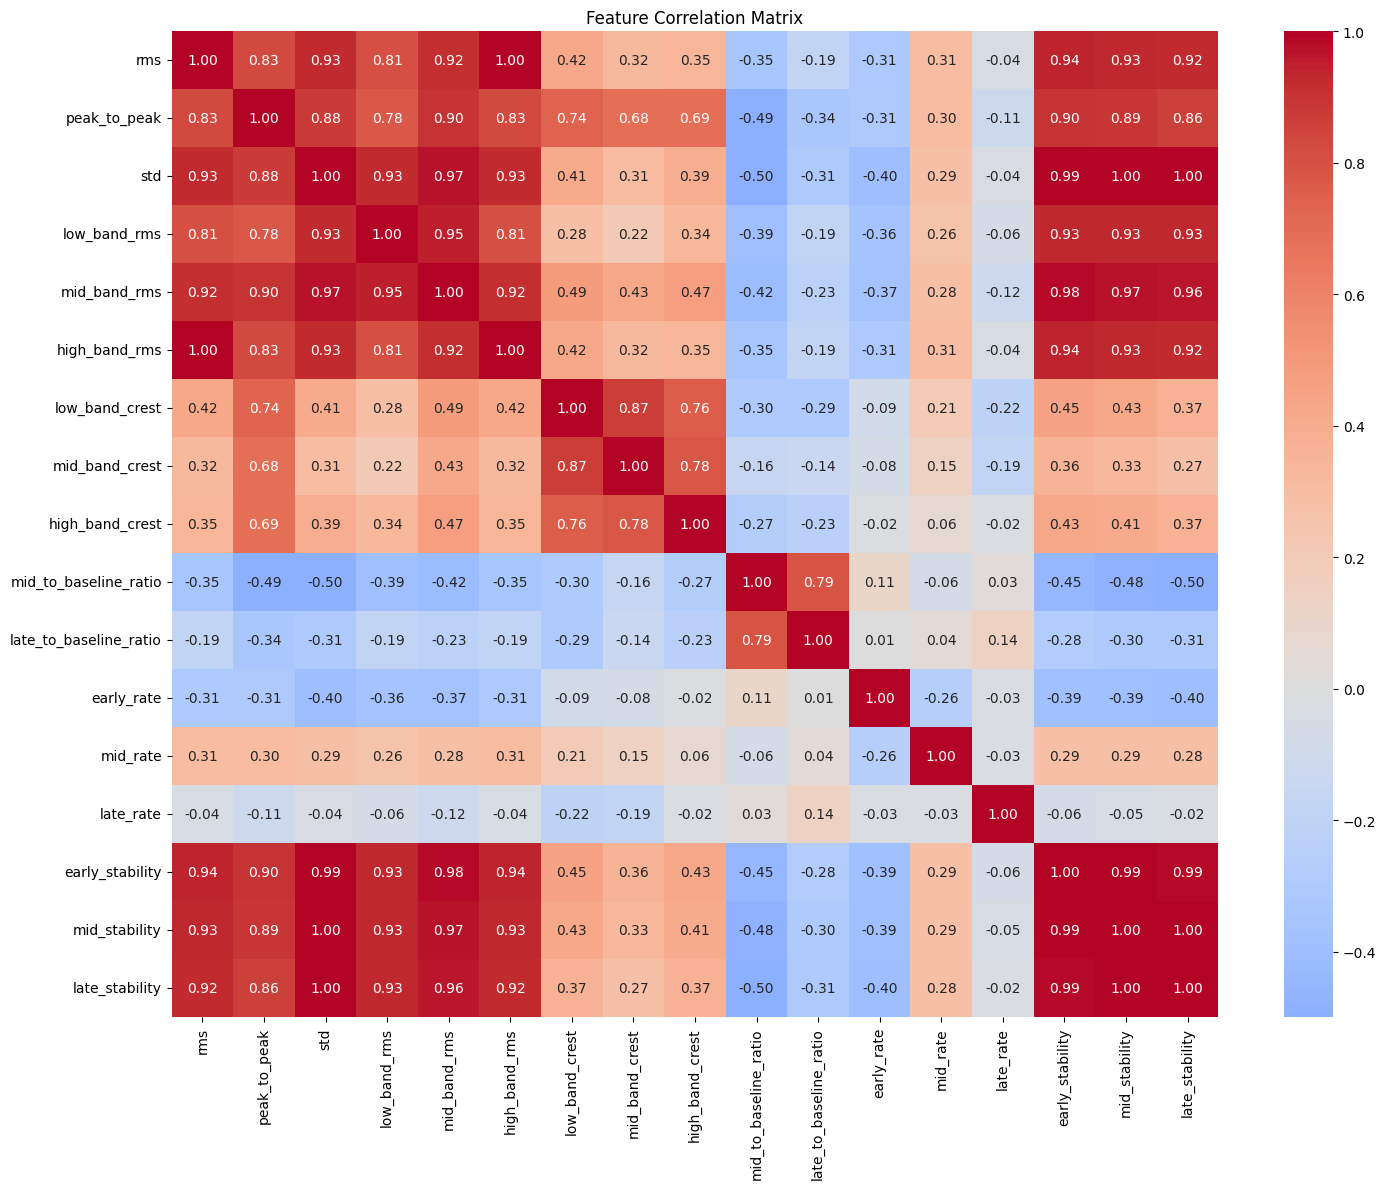


Most Important Feature Correlations:

Top 10 strongest correlations:
rms                  - high_band_rms       : 1.000
std                  - mid_stability       : 0.999
std                  - late_stability      : 0.999
mid_stability        - late_stability      : 0.997
early_stability      - mid_stability       : 0.994
std                  - early_stability     : 0.991
early_stability      - late_stability      : 0.986
mid_band_rms         - early_stability     : 0.984
mid_band_rms         - mid_stability       : 0.975
std                  - mid_band_rms        : 0.968


In [12]:
# Cell 2: Create feature matrix and correlation analysis
def create_correlation_matrix():
    """
    Create and analyze correlation matrix for all features
    """
    # Prepare data for each failure type
    feature_data = []
    
    # Inner Race (Set 1, Bearing 3, Channel 5)
    files_1 = sorted(data_path_1.glob("*"))
    sample_indices = np.linspace(0, len(files_1)-1, 20, dtype=int)
    
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        features = extract_all_features(data, 4)  # Channel 5
        features['failure_type'] = 'inner_race'
        feature_data.append(features)
    
    # Roller (Set 1, Bearing 4, Channel 7)
    roller_idx = int(len(files_1) * 0.813)
    roller_indices = np.linspace(0, roller_idx, 20, dtype=int)
    
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        features = extract_all_features(data, 6)  # Channel 7
        features['failure_type'] = 'roller'
        feature_data.append(features)
    
    # Outer Race (Set 2, Bearing 1, Channel 1)
    files_2 = sorted(data_path_2.glob("*"))
    sample_indices_2 = np.linspace(0, len(files_2)-1, 20, dtype=int)
    
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        features = extract_all_features(data, 0)  # Channel 1
        features['failure_type'] = 'outer_race'
        feature_data.append(features)
    
    # Create DataFrame
    df = pd.DataFrame(feature_data)
    
    # Create correlation matrix
    feature_cols = [col for col in df.columns if col != 'failure_type']
    correlation_matrix = df[feature_cols].corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print most important correlations
    print("\nMost Important Feature Correlations:")
    correlations = []
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            corr = correlation_matrix.iloc[i, j]
            correlations.append((feature_cols[i], feature_cols[j], abs(corr)))
    
    # Sort and print top correlations
    correlations.sort(key=lambda x: x[2], reverse=True)
    print("\nTop 10 strongest correlations:")
    for feat1, feat2, corr in correlations[:10]:
        print(f"{feat1:20} - {feat2:20}: {corr:.3f}")

# Run the analysis
create_correlation_matrix()

In [16]:
from scipy import signal  # Add this import

def calculate_psd(data, channel, fs=20000):
    """
    Calculate Power Spectral Density features
    """
    time_series = data[:, channel]
    frequencies, psd = signal.periodogram(time_series, fs=fs)
    
    # Extract meaningful PSD features
    features = {
        'psd_max': np.max(psd),
        'psd_mean': np.mean(psd),
        # Power in our key bands
        'psd_low': np.mean(psd[(frequencies >= 20) & (frequencies < 1000)]),
        'psd_mid': np.mean(psd[(frequencies >= 1000) & (frequencies < 3000)]),
        'psd_high': np.mean(psd[(frequencies >= 3000) & (frequencies < 5000)]),
        # Ratios between bands
        'psd_mid_to_low': np.mean(psd[(frequencies >= 1000) & (frequencies < 3000)]) / 
                         (np.mean(psd[(frequencies >= 20) & (frequencies < 1000)]) + 1e-10)
    }
    return features

def calculate_spectrogram(data, channel, fs=20000):
    """
    Calculate Spectrogram features
    """
    time_series = data[:, channel]
    f, t, Sxx = signal.spectrogram(time_series, fs=fs)
    
    # Extract meaningful spectrogram features
    early_spec = Sxx[:, :len(Sxx[0])//3]
    mid_spec = Sxx[:, len(Sxx[0])//3:2*len(Sxx[0])//3]
    late_spec = Sxx[:, 2*len(Sxx[0])//3:]
    
    features = {
        'spec_early_mean': np.mean(early_spec),
        'spec_mid_mean': np.mean(mid_spec),
        'spec_late_mean': np.mean(late_spec),
        'spec_progression': np.mean(late_spec) / (np.mean(early_spec) + 1e-10),
        'spec_variance': np.var(Sxx),
        'spec_max_energy': np.max(Sxx)
    }
    return features

In [17]:
def extract_all_features(data, channel):
    """
    Updated feature extraction including PSD and Spectrogram
    """
    # Get existing features
    basic_stats = extract_bearing_features(data, [channel])
    freq_bands = analyze_frequency_bands(data, channel)
    freq_chars = analyze_signal_characteristics(freq_bands)
    time_series = data[:, channel]
    degradation_features = calculate_degradation_features(time_series)
    
    # Add new PSD and Spectrogram features
    psd_features = calculate_psd(data, channel)
    spec_features = calculate_spectrogram(data, channel)
    
    # Combine all features
    features = {
        # [Previous features remain the same]
        **degradation_features,
        **psd_features,
        **spec_features
    }
    
    return features

Processing files...

Shape of feature matrix: (60, 21)

Feature list:
['mid_to_baseline_ratio', 'late_to_baseline_ratio', 'early_rate', 'mid_rate', 'late_rate', 'early_stability', 'mid_stability', 'late_stability', 'psd_max', 'psd_mean', 'psd_low', 'psd_mid', 'psd_high', 'psd_mid_to_low', 'spec_early_mean', 'spec_mid_mean', 'spec_late_mean', 'spec_progression', 'spec_variance', 'spec_max_energy', 'failure_type']


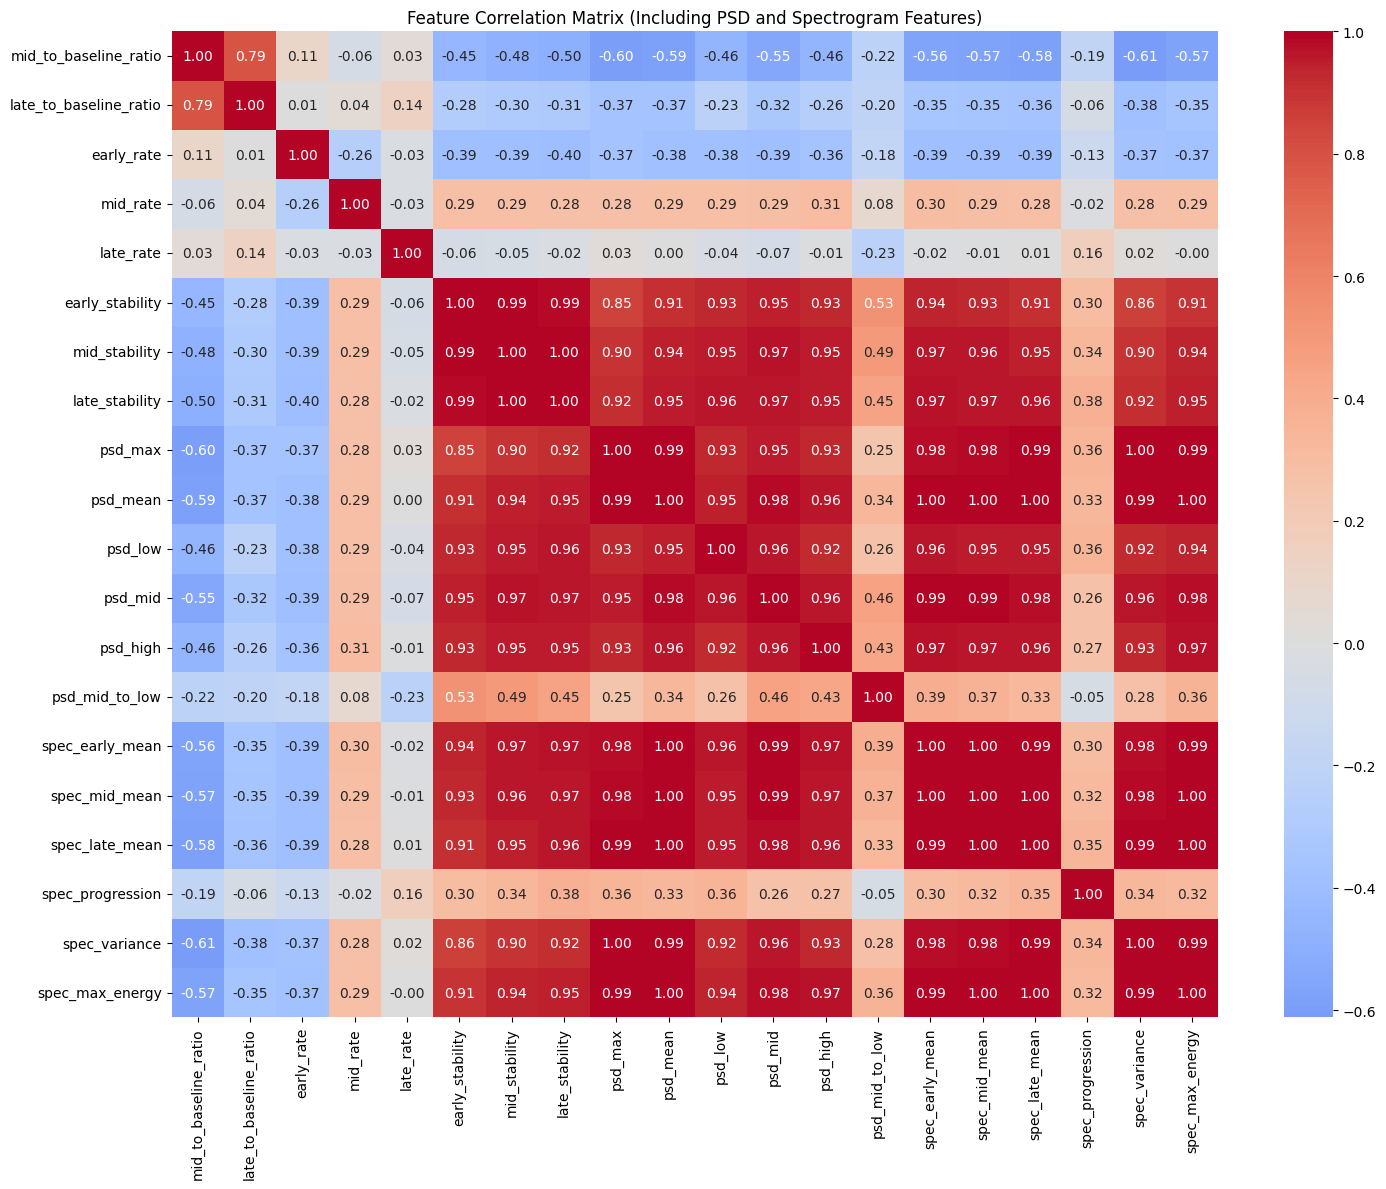


Top 10 strongest correlations:
psd_mean             - spec_late_mean      : 1.000
spec_early_mean      - spec_mid_mean       : 0.999
psd_max              - spec_variance       : 0.999
psd_mean             - spec_mid_mean       : 0.998
spec_mid_mean        - spec_late_mean      : 0.998
psd_mean             - spec_max_energy     : 0.997
mid_stability        - late_stability      : 0.997
spec_late_mean       - spec_max_energy     : 0.996
spec_mid_mean        - spec_max_energy     : 0.996
psd_mean             - spec_early_mean     : 0.995


In [18]:
# Update our correlation matrix creation to include new features
def create_correlation_matrix_with_new_features():
    """
    Create and analyze correlation matrix including PSD and Spectrogram features
    """
    # Prepare data for each failure type
    feature_data = []
    
    # Inner Race (Set 1, Bearing 3, Channel 5)
    files_1 = sorted(data_path_1.glob("*"))
    sample_indices = np.linspace(0, len(files_1)-1, 20, dtype=int)
    
    print("Processing files...")
    
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        # Get all features including new PSD and Spectrogram features
        basic_features = extract_all_features(data, 4)  # Channel 5
        psd_features = calculate_psd(data, 4)
        spec_features = calculate_spectrogram(data, 4)
        
        # Combine all features
        features = {**basic_features, **psd_features, **spec_features}
        features['failure_type'] = 'inner_race'
        feature_data.append(features)
    
    # Roller (Set 1, Bearing 4, Channel 7)
    roller_idx = int(len(files_1) * 0.813)
    roller_indices = np.linspace(0, roller_idx, 20, dtype=int)
    
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        basic_features = extract_all_features(data, 6)  # Channel 7
        psd_features = calculate_psd(data, 6)
        spec_features = calculate_spectrogram(data, 6)
        
        features = {**basic_features, **psd_features, **spec_features}
        features['failure_type'] = 'roller'
        feature_data.append(features)
    
    # Outer Race (Set 2, Bearing 1, Channel 1)
    files_2 = sorted(data_path_2.glob("*"))
    sample_indices_2 = np.linspace(0, len(files_2)-1, 20, dtype=int)
    
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        basic_features = extract_all_features(data, 0)  # Channel 1
        psd_features = calculate_psd(data, 0)
        spec_features = calculate_spectrogram(data, 0)
        
        features = {**basic_features, **psd_features, **spec_features}
        features['failure_type'] = 'outer_race'
        feature_data.append(features)
    
    # Create DataFrame
    df = pd.DataFrame(feature_data)
    
    print("\nShape of feature matrix:", df.shape)
    print("\nFeature list:")
    print(df.columns.tolist())
    
    # Create correlation matrix
    feature_cols = [col for col in df.columns if col != 'failure_type']
    correlation_matrix = df[feature_cols].corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Matrix (Including PSD and Spectrogram Features)')
    plt.tight_layout()
    plt.show()
    
    # Print most important correlations
    print("\nTop 10 strongest correlations:")
    correlations = []
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            corr = correlation_matrix.iloc[i, j]
            correlations.append((feature_cols[i], feature_cols[j], abs(corr)))
    
    correlations.sort(key=lambda x: x[2], reverse=True)
    for feat1, feat2, corr in correlations[:10]:
        print(f"{feat1:20} - {feat2:20}: {corr:.3f}")

# Run the updated analysis
create_correlation_matrix_with_new_features()

In [20]:
def prepare_final_dataset():
    """
    Prepare final dataset for ML with selected features
    """
    # List to store all data
    all_data = []
    
    print("Preparing final dataset...")
    
    # 1. Select features based on what we actually have
    selected_features = [
        # Degradation features
        'mid_to_baseline_ratio',
        'late_to_baseline_ratio',
        'early_rate',
        'mid_rate',
        'late_rate',
        'early_stability',
        'mid_stability',
        'late_stability',
        
        # PSD features
        'psd_max',
        'psd_mean',
        'psd_low',
        'psd_mid',
        'psd_high',
        'psd_mid_to_low',
        
        # Spectrogram features
        'spec_early_mean',
        'spec_mid_mean',
        'spec_late_mean',
        'spec_progression',
        'spec_variance',
        'spec_max_energy'
    ]
    
    # Rest of the function remains same...
    # Inner Race (Set 1, Bearing 3, Channels 5&6)
    files_1 = sorted(data_path_1.glob("*"))
    sample_indices = np.linspace(0, len(files_1)-1, 20, dtype=int)
    
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        # Process both channels
        for channel in [4, 5]:  # Python indices for channels 5&6
            features = extract_all_features(data, channel)
            selected_data = {feat: features[feat] for feat in selected_features}
            selected_data['failure_type'] = 'inner_race'
            selected_data['channel'] = f'channel_{channel+1}'
            selected_data['time_percentage'] = (idx / len(files_1)) * 100
            all_data.append(selected_data)
    
    # Roller (Set 1, Bearing 4, Channels 7&8)
    roller_idx = int(len(files_1) * 0.813)
    roller_indices = np.linspace(0, roller_idx, 20, dtype=int)
    
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        for channel in [6, 7]:  # Python indices for channels 7&8
            features = extract_all_features(data, channel)
            selected_data = {feat: features[feat] for feat in selected_features}
            selected_data['failure_type'] = 'roller'
            selected_data['channel'] = f'channel_{channel+1}'
            selected_data['time_percentage'] = (idx / len(files_1)) * 100
            all_data.append(selected_data)
    
    # Outer Race (Set 2)
    files_2 = sorted(data_path_2.glob("*"))
    sample_indices_2 = np.linspace(0, len(files_2)-1, 20, dtype=int)
    
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        features = extract_all_features(data, 0)  # Channel 1
        selected_data = {feat: features[feat] for feat in selected_features}
        selected_data['failure_type'] = 'outer_race'
        selected_data['channel'] = 'channel_1'
        selected_data['time_percentage'] = (idx / len(files_2)) * 100
        all_data.append(selected_data)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    # Add binary classification columns
    df['is_healthy'] = df['time_percentage'] < 70
    
    print("\nDataset Summary:")
    print(f"Total samples: {len(df)}")
    print(f"Features selected: {len(selected_features)}")
    print("\nSamples per failure type:")
    print(df['failure_type'].value_counts())
    print("\nHealthy vs Failing distribution:")
    print(df['is_healthy'].value_counts())
    
    return df

# Create final dataset
final_df = prepare_final_dataset()

# Save dataset for Phase 4
final_df.to_csv('bearing_failure_dataset.csv', index=False)
print("\nDataset saved to 'bearing_failure_dataset.csv'")

Preparing final dataset...

Dataset Summary:
Total samples: 100
Features selected: 20

Samples per failure type:
failure_type
inner_race    40
roller        40
outer_race    20
Name: count, dtype: int64

Healthy vs Failing distribution:
is_healthy
True     76
False    24
Name: count, dtype: int64

Dataset saved to 'bearing_failure_dataset.csv'
